# Import Libraries

In [3]:
pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pycaret

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 18.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import deepchem as dc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from pycaret.regression import *
import warnings

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [10]:
warnings.filterwarnings("ignore")

# Loading Data 

In [11]:
df_train = pd.read_csv('/kaggle/input/aqueous-solubility-predictioin/train.csv')
df_test = pd.read_csv('/kaggle/input/aqueous-solubility-predictioin/test.csv')

In [17]:
df_train.shape

(6987, 27)

In [ ]:
df_train.info()

In [ ]:
smiles_list = df_train['SMILES'][:10]

In [ ]:
mol_list = []
for smile in smiles_list:
    mol = Chem.MolFromSmiles(smile)
    mol_list.append(mol)
img = Chem.Draw.MolsToGridImage(mol_list, molsPerRow = 5)
img

# Morgan Finger Print

In [ ]:
df_train.columns

In [ ]:
X = df_train.drop(columns = ['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'SD',
       'Ocurrences', 'Group','comp_id'])

In [ ]:
reg = setup(
    X, 
    target = 'Solubility', 
    session_id=123, 
    train_size=0.8, 
)

In [ ]:
best_top3_models = compare_models(n_select=3)

In [ ]:
# Define a function to featurize a SMILES string
def featurize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    features = np.array(list(fp.ToBitString())).astype(float)
    return features

In [ ]:
df_train['Solubility'].max()

In [ ]:
df_train['Solubility'].min()

In [ ]:
# featurize the molecules
X = np.array([featurize_smiles(smiles) for smiles in df_train['SMILES']])

In [ ]:
X

In [ ]:
X.shape

In [ ]:
X = pd.DataFrame(X)
X['Solubility'] = df_train['Solubility']

In [ ]:
reg = setup(
    X, 
    target = 'Solubility', 
    session_id=123, 
    train_size=0.8, 

)

In [ ]:
best_top3_models = compare_models(n_select=3)

# Descriptors

In [44]:
from rdkit.Chem import MolFromSmiles, Descriptors, MolFromSmarts


def create_descriptors(smiles):
    
    mol = MolFromSmiles(smiles)

    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    rotb = Descriptors.NumRotatableBonds(mol)
    arom_proportion = len(mol.GetSubstructMatches(MolFromSmarts("a"))) / Descriptors.HeavyAtomCount(mol)
    
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    non_carbon_proportion = len(mol.GetSubstructMatches(MolFromSmarts("[!#6]"))) / Descriptors.HeavyAtomCount(mol)
    psa = Descriptors.TPSA(mol, includeSandP=True)
    # plus some extra one
    fsp3 = Descriptors.FractionCSP3(mol)
    
    return mw, logp, rotb, arom_proportion, hbd, hba, non_carbon_proportion, psa, fsp3

In [45]:
descriptors = [create_descriptors(smiles) for smiles in df_train['SMILES']]
col_names = ['mw', 'logp', 'rotb', 'ap', 'hbd', 'hba', 'non_cp', 'psa', 'fsp3']
train = pd.DataFrame(descriptors, columns=col_names)
train = train.join(df_train['Solubility'], how="left")

[11:51:17] WARNING: not removing hydrogen atom without neighbors
[11:51:17] WARNING: not removing hydrogen atom without neighbors
[11:51:17] WARNING: not removing hydrogen atom without neighbors
[11:51:17] WARNING: not removing hydrogen atom without neighbors
[11:51:17] WARNING: not removing hydrogen atom without neighbors
[11:52:14] WARNING: not removing hydrogen atom without neighbors
[11:52:14] WARNING: not removing hydrogen atom without neighbors
[11:52:14] WARNING: not removing hydrogen atom without neighbors
[11:52:14] WARNING: not removing hydrogen atom without neighbors
[11:52:14] WARNING: not removing hydrogen atom without neighbors
[11:52:14] WARNING: not removing hydrogen atom without neighbors
[11:52:14] WARNING: not removing hydrogen atom without neighbors
[11:52:15] WARNING: not removing hydrogen atom without neighbors
[11:52:15] WARNING: not removing hydrogen atom without neighbors
[11:52:15] WARNING: not removing hydrogen atom without neighbors
[11:52:15] WARNING: not r

In [46]:
train

,mw,logp,rotb,ap,hbd,hba,non_cp,psa,fsp3,Solubility
0,186.339,4.16360,10,0.000000,0,1,0.076923,9.23,1.000000,-4.270304
1,197.146,0.81580,2,0.428571,1,5,0.428571,81.83,0.250000,-3.060000
2,88.150,1.43290,3,0.000000,0,1,0.166667,9.23,1.000000,-0.680600
3,193.249,3.34208,2,0.800000,0,1,0.066667,23.79,0.071429,-2.943700
4,153.225,1.20220,0,0.000000,0,2,0.181818,20.31,0.888889,0.416700
...,...,...,...,...,...,...,...,...,...,...
6982,277.276,0.91900,4,0.300000,1,4,0.300000,83.91,0.357143,-1.590000
6983,212.333,3.84780,5,0.000000,1,1,0.133333,37.30,0.923077,-4.281695
6984,279.340,2.66700,2,0.300000,2,3,0.300000,70.67,0.428571,-2.934200
6985,333.371,3.58270,7,0.450000,0,7,0.400000,120.80,0.416667,-5.190500


In [47]:
reg = setup(
    train, 
    target = 'Solubility', 
    session_id=123, 
    train_size=0.8, 
    transformation = True,
    normalize = True
)

,Description,Value
0,Session id,123
1,Target,Solubility
2,Target type,Regression
3,Original data shape,"(6987, 10)"
4,Transformed data shape,"(6987, 10)"
5,Transformed train set shape,"(5589, 10)"
6,Transformed test set shape,"(1398, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


In [48]:
best_top3_models = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.7999,1.3566,1.1632,0.7585,0.3165,1.8376,4.2430
lightgbm,Light Gradient Boosting Machine,0.8188,1.3877,1.1764,0.7530,0.3217,1.7786,0.3050
et,Extra Trees Regressor,0.8037,1.3886,1.1767,0.7530,0.3216,1.8142,1.1050
rf,Random Forest Regressor,0.8181,1.4216,1.1906,0.7474,0.3227,1.6830,1.8050
xgboost,Extreme Gradient Boosting,0.8349,1.4683,1.2099,0.7388,0.3308,1.8728,0.9750
gbr,Gradient Boosting Regressor,0.8724,1.5009,1.2236,0.7332,0.3323,1.8873,0.6620
knn,K Neighbors Regressor,0.8975,1.6198,1.2718,0.7119,0.3471,2.2612,0.1220
ada,AdaBoost Regressor,1.1082,2.0745,1.4396,0.6315,0.3813,3.8168,0.2270
br,Bayesian Ridge,1.1187,2.3887,1.5396,0.5751,0.3894,2.9871,0.0660
ridge,Ridge Regression,1.1185,2.3888,1.5397,0.5750,0.3895,2.9847,0.0650


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [49]:
additional_col = [ 'MolMR', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
                   'NumAliphaticRings', 'RingCount', 'LabuteASA', 'BalabanJ','BertzCT']

In [50]:
df = train.join(df_train[additional_col], how="left")

In [51]:
reg = setup(
    df, 
    target = 'Solubility', 
    session_id=123, 
    train_size=0.8, 
    numeric_features= list(df.drop(columns = ['Solubility']).columns),
    transformation = True,
    normalize = True
)

,Description,Value
0,Session id,123
1,Target,Solubility
2,Target type,Regression
3,Original data shape,"(6987, 19)"
4,Transformed data shape,"(6987, 19)"
5,Transformed train set shape,"(5589, 19)"
6,Transformed test set shape,"(1398, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [52]:
best_top3_models = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.7676,1.2483,1.1156,0.7785,0.3086,1.5603,1.6670
catboost,CatBoost Regressor,0.7733,1.2650,1.1234,0.7752,0.3082,1.6039,5.8920
lightgbm,Light Gradient Boosting Machine,0.7792,1.2686,1.1243,0.7748,0.3092,1.5977,0.3680
rf,Random Forest Regressor,0.7868,1.2863,1.1329,0.7717,0.3104,1.5094,3.0810
xgboost,Extreme Gradient Boosting,0.8007,1.3563,1.1634,0.7589,0.3167,1.7937,1.9660
gbr,Gradient Boosting Regressor,0.8440,1.4090,1.1855,0.7497,0.3226,1.6846,1.1460
knn,K Neighbors Regressor,0.8771,1.5439,1.2410,0.7262,0.3372,2.0412,0.1670
ada,AdaBoost Regressor,1.1161,2.0827,1.4422,0.6303,0.3885,3.9699,0.4470
br,Bayesian Ridge,1.0911,2.3193,1.5168,0.5872,0.3845,2.6154,0.0910
ridge,Ridge Regression,1.0906,2.3200,1.5170,0.5871,0.3846,2.6100,0.0970


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [53]:
best = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8170,1.4718,1.2132,0.7559,0.3043,1.0686
1,0.7953,1.3229,1.1502,0.7744,0.3213,1.2508
2,0.7746,1.2344,1.1111,0.7743,0.3154,1.6437
3,0.7621,1.1770,1.0849,0.7876,0.3102,1.1524
4,0.8068,1.3548,1.1640,0.7716,0.2988,2.8732
5,0.7397,1.1738,1.0834,0.7737,0.3101,1.3848
6,0.6947,0.9471,0.9732,0.8313,0.2694,0.8933
7,0.7890,1.2535,1.1196,0.7756,0.3310,1.2440
8,0.7620,1.3254,1.1512,0.7819,0.3047,3.1084


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
print(best)

ExtraTreesRegressor(n_jobs=-1, random_state=123)


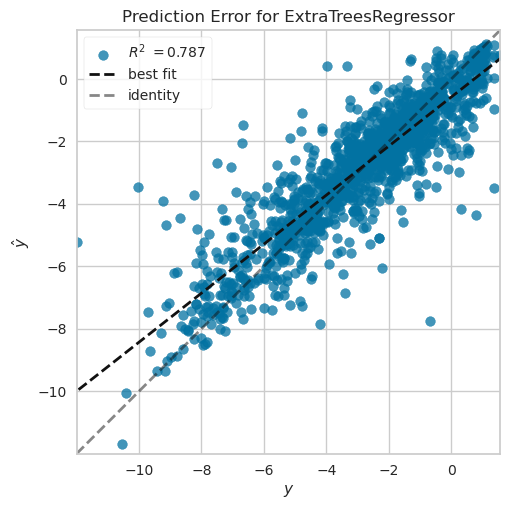

In [55]:
plot_model(best, 'error')

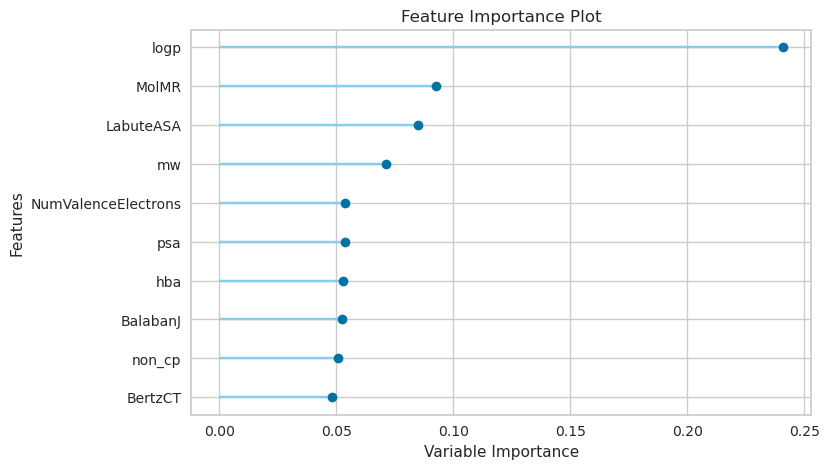

In [56]:
plot_model(best, 'feature')

In [ ]:
prediction_holdout = predict_model(best)

In [ ]:
bagged_ensemble = ensemble_model(best)

In [ ]:
bagged_ensemble_50estm = ensemble_model(best, n_estimators=50)

In [ ]:
boosted_ensemble = ensemble_model(best, method = 'Boosting')

In [ ]:
boosted_ensemble_50estm = ensemble_model(best, method='Boosting', n_estimators=50)

In [ ]:
stacker = stack_models(best_top3_models)

In [ ]:
# train on full dataset and create the final model
final_model = finalize_model(best)

In [ ]:
descriptors = [create_esol_descriptors(smiles) for smiles in df_test['SMILES']]
col_names = ['mw', 'logp', 'rotb', 'ap', 'hbd', 'hba', 'non_cp', 'psa', 'fsp3']
test = pd.DataFrame(descriptors, columns=col_names)

In [ ]:
df = test.join(df_test[additional_col], how="left")

In [ ]:
df = predict_model(final_model, data=df)

In [ ]:
df.rename(columns = {'prediction_label': 'Solubility'}, inplace = True)

In [ ]:
df['comp_id'] = df_test['comp_id'].values

In [ ]:
df[['comp_id', 'Solubility']].to_csv('/kaggle/working/submission.csv', index=False)

# Mol2VecFingerprint

In [47]:
smiles = ['CCC']
featurizer = dc.feat.Mol2VecFingerprint()
features = featurizer.featurize(smiles)

In [48]:
features = featurizer.featurize(df_train['SMILES'])

[19:05:27] WARNING: not removing hydrogen atom without neighbors
[19:05:27] WARNING: not removing hydrogen atom without neighbors
[19:05:27] WARNING: not removing hydrogen atom without neighbors
[19:05:27] WARNING: not removing hydrogen atom without neighbors
[19:05:28] WARNING: not removing hydrogen atom without neighbors
[19:05:29] WARNING: not removing hydrogen atom without neighbors
[19:05:30] WARNING: not removing hydrogen atom without neighbors
[19:05:30] WARNING: not removing hydrogen atom without neighbors
[19:05:30] WARNING: not removing hydrogen atom without neighbors
[19:05:30] WARNING: not removing hydrogen atom without neighbors
[19:05:31] WARNING: not removing hydrogen atom without neighbors
[19:05:32] WARNING: not removing hydrogen atom without neighbors
[19:05:32] WARNING: not removing hydrogen atom without neighbors
[19:05:32] WARNING: not removing hydrogen atom without neighbors
[19:05:33] WARNING: not removing hydrogen atom without neighbors
[19:05:33] WARNING: not r

In [49]:
features.shape

(6987, 300)

In [50]:
df = pd.DataFrame(features)
df['Solubility'] = df_train['Solubility']

In [51]:
reg = setup(
    df, 
    target = 'Solubility', 
    session_id=123, 
    train_size=0.8, 
    transformation = True,
)

,Description,Value
0,Session id,123
1,Target,Solubility
2,Target type,Regression
3,Original data shape,"(6987, 301)"
4,Transformed data shape,"(6987, 301)"
5,Transformed train set shape,"(5589, 301)"
6,Transformed test set shape,"(1398, 301)"
7,Numeric features,300
8,Preprocess,True
9,Imputation type,simple


In [52]:
best_top3_models = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.7916,1.2371,1.1118,0.7802,0.3100,1.9939,44.6060
lightgbm,Light Gradient Boosting Machine,0.8350,1.3486,1.1604,0.7605,0.3222,1.8886,7.4310
et,Extra Trees Regressor,0.8630,1.4447,1.2012,0.7436,0.3302,1.8609,13.0180
rf,Random Forest Regressor,0.8880,1.4998,1.2238,0.7337,0.3357,2.0275,43.6240
xgboost,Extreme Gradient Boosting,0.8740,1.5006,1.2245,0.7329,0.3389,1.8386,15.8110
gbr,Gradient Boosting Regressor,0.9460,1.6114,1.2685,0.7140,0.3513,2.3431,20.2460
knn,K Neighbors Regressor,0.9394,1.6992,1.3024,0.6978,0.3589,2.4011,0.2180
br,Bayesian Ridge,1.0009,1.9782,1.4053,0.6482,0.3676,2.4360,0.2770
ridge,Ridge Regression,1.0053,1.9971,1.4121,0.6447,0.3704,2.4372,0.1510
lr,Linear Regression,1.0057,1.9980,1.4124,0.6445,0.3705,2.4392,2.5980


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

# RDKitDescriptors

In [53]:
smiles = ['CC(=O)OC1=CC=CC=C1C(=O)O']
featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(smiles)

In [54]:
features.shape

(1, 208)

In [55]:
features = featurizer.featurize(df_train['SMILES'])

[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:43] WARNING: not removing hydrogen atom without neighbors
[19:35:50] WARNING: not removing hydrogen atom without neighbors
[19:35:50] WARNING: not removing hydrogen atom without neighbors
[19:35:50] WARNING: not removing hydrogen atom without neighbors
[19:35:55] WARNING: not r

In [56]:
df = pd.DataFrame(features)
df['Solubility'] = df_train['Solubility']

In [57]:
reg = setup(
    df, 
    target = 'Solubility', 
    session_id=123, 
    train_size=0.8, 
)

,Description,Value
0,Session id,123
1,Target,Solubility
2,Target type,Regression
3,Original data shape,"(6987, 209)"
4,Transformed data shape,"(6987, 209)"
5,Transformed train set shape,"(5589, 209)"
6,Transformed test set shape,"(1398, 209)"
7,Numeric features,208
8,Rows with missing values,8.7%
9,Preprocess,True


In [58]:
best_top3_models = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.6791,1.0047,1.0013,0.8217,0.2773,1.3199,17.2500
lightgbm,Light Gradient Boosting Machine,0.7044,1.0458,1.0213,0.8143,0.2823,1.4467,2.2970
et,Extra Trees Regressor,0.6984,1.0605,1.0288,0.8119,0.2847,1.4650,7.0560
rf,Random Forest Regressor,0.7333,1.1316,1.0628,0.7991,0.2918,1.5009,13.6190
xgboost,Extreme Gradient Boosting,0.7271,1.1430,1.0680,0.7972,0.2925,1.5181,4.4560
gbr,Gradient Boosting Regressor,0.7889,1.2397,1.1124,0.7797,0.3095,1.5823,4.7830
knn,K Neighbors Regressor,0.8917,1.5754,1.2544,0.7201,0.3448,1.9109,0.6510
ada,AdaBoost Regressor,1.0781,1.9336,1.3899,0.6567,0.3795,3.8499,1.9650
dt,Decision Tree Regressor,1.0059,2.1725,1.4733,0.6134,0.3933,2.1668,0.5630
en,Elastic Net,1.2036,2.6081,1.6123,0.5370,0.4085,3.1806,0.3410


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

# MordredDescriptors

In [104]:
!pip install mordred

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176721 sha256=5a4c1f9d350a756b913cfa9c35496e94b4daca5cc678eb8ef9b3fc07bcff4246
  Stored in directory: /root/.cache/pip/wheels/8a/d5/a0/36c7bdca2524dbe6886fd6c356d0b28a4f0c0ccf68ea3ef9ae
Successfully built mordred


In [105]:
smiles = ['CC(=O)OC1=CC=CC=C1C(=O)O']
featurizer = dc.feat.MordredDescriptors()
features = featurizer.featurize(smiles)

In [106]:
features

array([[ 9.54906713,  9.03919229,  1.        , ..., 66.        ,
         5.69444444,  2.97222222]])

In [107]:
features = featurizer.featurize(df_train['SMILES'])

[20:45:16] WARNING: not removing hydrogen atom without neighbors
[20:45:16] WARNING: not removing hydrogen atom without neighbors
[20:45:16] WARNING: not removing hydrogen atom without neighbors
[20:45:16] WARNING: not removing hydrogen atom without neighbors
[20:45:37] WARNING: not removing hydrogen atom without neighbors
[20:45:37] WARNING: not removing hydrogen atom without neighbors
[20:45:37] WARNING: not removing hydrogen atom without neighbors
[20:45:37] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not removing hydrogen atom without neighbors
[20:45:39] WARNING: not r

In [ ]:
features.shape

In [108]:
df = pd.DataFrame(features)
df['Solubility'] = df_train['Solubility']

In [122]:
reg = setup(
    df, 
    target = 'Solubility', 
    session_id=123, 
    train_size=0.8, 
)

,Description,Value
0,Session id,123
1,Target,Solubility
2,Target type,Regression
3,Original data shape,"(6987, 1614)"
4,Transformed data shape,"(6987, 1614)"
5,Transformed train set shape,"(5589, 1614)"
6,Transformed test set shape,"(1398, 1614)"
7,Numeric features,1613
8,Preprocess,True
9,Imputation type,simple


In [123]:
best_top3_models = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.6681,0.9532,0.9751,0.8308,0.2746,1.3098,156.6660
lightgbm,Light Gradient Boosting Machine,0.6830,0.9891,0.9932,0.8244,0.2786,1.2736,27.5670
et,Extra Trees Regressor,0.6809,0.9911,0.9944,0.8242,0.2761,1.3413,0.5800
rf,Random Forest Regressor,0.7144,1.0687,1.0327,0.8102,0.2860,1.5059,150.5840
xgboost,Extreme Gradient Boosting,0.7225,1.0822,1.0390,0.8078,0.2916,1.4308,48.8480
gbr,Gradient Boosting Regressor,0.7532,1.1251,1.0597,0.8003,0.2972,1.9541,61.7960
ada,AdaBoost Regressor,1.0126,1.7184,1.3102,0.6951,0.3524,3.6074,20.3780
omp,Orthogonal Matching Pursuit,0.8488,1.8890,1.3414,0.6694,0.3274,2.4079,0.4840
dt,Decision Tree Regressor,1.0129,2.1680,1.4713,0.6138,0.3905,2.2074,4.0410
knn,K Neighbors Regressor,1.1319,2.3760,1.5402,0.5781,0.4154,2.5778,0.5820


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [115]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7013,1.1014,1.0495,0.8174,0.2758,0.9655
1,0.7169,1.0973,1.0475,0.8128,0.2902,1.1171
2,0.7022,1.0060,1.0030,0.8161,0.2864,1.4396
3,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
4,0.6818,1.0164,1.0082,0.8286,0.2743,2.8283
5,0.6526,0.9158,0.9569,0.8234,0.2820,1.3258
6,0.6256,0.7895,0.8885,0.8594,0.2428,0.6619
7,0.6857,0.9462,0.9727,0.8306,0.2878,1.2055
8,0.6802,1.0506,1.0250,0.8271,0.2688,1.5208


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [116]:
final_model = finalize_model(et)

In [117]:
test_features = featurizer.featurize(df_test['SMILES'])

[22:47:44] WARNING: not removing hydrogen atom without neighbors
[22:47:44] WARNING: not removing hydrogen atom without neighbors
[22:47:44] WARNING: not removing hydrogen atom without neighbors
[22:47:44] WARNING: not removing hydrogen atom without neighbors
[22:50:03] WARNING: not removing hydrogen atom without neighbors
[22:50:03] WARNING: not removing hydrogen atom without neighbors
[22:50:03] WARNING: not removing hydrogen atom without neighbors
[22:50:03] WARNING: not removing hydrogen atom without neighbors
[22:50:12] WARNING: not removing hydrogen atom without neighbors
[22:50:12] WARNING: not removing hydrogen atom without neighbors
[22:50:12] WARNING: not removing hydrogen atom without neighbors
[22:50:12] WARNING: not removing hydrogen atom without neighbors
[22:51:59] WARNING: not removing hydrogen atom without neighbors
[22:51:59] WARNING: not removing hydrogen atom without neighbors
[22:51:59] WARNING: not removing hydrogen atom without neighbors
[22:51:59] WARNING: not r

In [118]:
submission = pd.DataFrame(test_features)

In [121]:
submission = predict_model(final_model, data=submission)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# GraphConvModel

In [ ]:
pip install deepchem

In [ ]:
import deepchem as dc
from deepchem.models import GraphConvModel

In [ ]:
featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

In [ ]:
features = featurizer.featurize(df_train['SMILES'])

In [ ]:
y = df_train['Solubility'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(features, y, test_size = 0.2)

In [ ]:
train_dataset = dc.data.NumpyDataset(X = X_train, y = y_train)
val_dataset = dc.data.NumpyDataset(X = X_val, y = y_val)

In [ ]:
model = GraphConvModel(n_tasks = 1, mode = 'regression', batch_size  = 64,
                      graph_conv_layers = [128, 64, 64, 32], dense_layer_size = 128,
                      n_classes = 1)

In [ ]:
model.fit(train_dataset, nb_epoch=100,)

In [ ]:
# Evaluate the model on the test dataset
metric = dc.metrics.Metric(dc.metrics.rms_score)
print(model.evaluate(val_dataset, [metric]))

In [ ]:
model = GraphConvModel(n_tasks = 1, mode = 'regression', batch_size  = 64,
                      graph_conv_layers = [128, 64, 64, 32], dense_layer_size = 128,
                      n_classes = 1)

In [ ]:
full_dataset = dc.data.NumpyDataset(X = features, y = y)

In [ ]:
model.fit(full_dataset, nb_epoch=100)

In [ ]:
test_features = featurizer.featurize(df_test['SMILES'])

In [ ]:
test_dataset = dc.data.NumpyDataset(test_features = features, y = df_test['Solubility'].values)

In [ ]:
prediction = model.predict(test_dataset)

# Pre-trained model

In [6]:
pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 77.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 80.8 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=c7c3dc2d0b974114aa9610afeac3c18538443b8ed627a3e177539dc5ce070159
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=0532ef1e515d1070f18e0e19bf864ec86a47217622eb4bf7400f284364b9a203
  Stored in directory: /root/.cache/pip/wheels/3d/7c/f1/f87f51d07a2513aa0fb128d5eb50

In [7]:
from simpletransformers.classification import ClassificationModel

In [12]:
train, val = train_test_split(df_train, test_size = 0.2)

In [13]:
train_dataset = train[["SMILES", "Solubility"]]
train_dataset = train_dataset.rename(columns={"Solubility": "labels", "SMILES": "text"})
val_dataset = val[["SMILES", "Solubility"]]
val_dataset = val_dataset.rename(columns={"Solubility": "labels", "SMILES": "text"})

In [14]:
model = ClassificationModel(
    "roberta",
    "seyonec/ChemBERTa_zinc250k_v2_40k",
    num_labels=1,
    args={
        "regression": True,
        "use_multiprocessing": True,
        "use_multiprocessing_for_evaluation": False,
    },
    use_cuda=True,
)

Some weights of the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k

In [15]:
model.train_model(
    train_df=train_dataset,
    eval_df = val_dataset,
    early_stopping_patience = 3,
    args={"num_train_epochs": 5,
          "optimizer" : "AdamW",
         "overwrite_output_dir": True},   
)

  0%|          | 0/5589 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/699 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/699 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/699 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/699 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/699 [00:00<?, ?it/s]

(3495, 1.3991677297084713)

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
result, model_outputs, wrong_predictions = model.eval_model(
    val_dataset, acc=mean_squared_error
)
print(result)

Running Evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

{'acc': 1.3534083008054374, 'eval_loss': 1.3527716824838094}


# Variational Autoencoder (VAE)

In [18]:
import tensorflow as tf
from rdkit import Chem
from rdkit.Chem import AllChem
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

In [19]:
# Convert the SMILES strings to molecular structures
mol_list = [Chem.MolFromSmiles(smiles) for smiles in df_train['SMILES']]
fp_list = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_list]
X = np.array(fp_list)

[11:40:10] WARNING: not removing hydrogen atom without neighbors
[11:40:10] WARNING: not removing hydrogen atom without neighbors
[11:40:10] WARNING: not removing hydrogen atom without neighbors
[11:40:10] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not removing hydrogen atom without neighbors
[11:40:11] WARNING: not r

In [20]:
# Define the VAE model architecture
latent_dim = 64
input_shape = X.shape[1:]
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(256, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [21]:
# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [22]:
# Define the encoder and decoder models
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(256, activation='relu')(x)
outputs = Dense(X.shape[1], activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [23]:
# Define the loss function
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs), axis=-1)
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [24]:
# Train the VAE model
history = vae.fit(X, X, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
44/44 [==============================] - 4s 11ms/step - loss: 0.0672 - val_loss: 0.0220
Epoch 2/5
44/44 [==============================] - 0s 6ms/step - loss: 0.0222 - val_loss: 0.0218
Epoch 3/5
44/44 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0217
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 0.0219 - val_loss: 0.0216
Epoch 5/5
44/44 [==============================] - 0s 6ms/step - loss: 0.0218 - val_loss: 0.0215


In [25]:
# Extract the latent space representation of the molecules
encoder_output = encoder.predict(X)[2]
encoder_output

219/219 [==============================] - 0s 2ms/step


array([[-1.0021626e+00,  2.0963273e+00, -4.5161849e-01, ...,
        -2.8899723e-01, -8.0226839e-01, -2.8991574e-01],
       [ 8.6992997e-01, -5.2907532e-01,  3.6832866e-01, ...,
         2.6744688e+00,  1.3415315e+00,  6.4632964e-01],
       [-1.7693729e+00, -1.7421577e+00,  2.1060874e-01, ...,
        -2.0389432e-01,  7.9456377e-01,  6.6259450e-01],
       ...,
       [ 2.8544319e-01,  2.5077788e-03, -1.2192211e+00, ...,
         1.0512631e+00,  1.3502088e+00, -2.2713926e-01],
       [-8.5775232e-01, -5.0655019e-01,  8.8296080e-01, ...,
         8.0382049e-02,  6.1055481e-02,  1.1096320e+00],
       [-6.6542548e-01, -4.0780434e-01,  2.1931797e-01, ...,
         1.7016176e+00, -1.0018973e+00,  1.6839882e+00]], dtype=float32)

In [26]:
# Train a solubility predictor using the latent space representation
y = df_train['Solubility'].values
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(latent_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer=tf.optimizers.Adam(1e-3))

In [27]:
model.fit(encoder_output, y, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
44/44 [==============================] - 1s 6ms/step - loss: 8.1301 - val_loss: 6.7231
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 5.6922 - val_loss: 6.4938
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 5.5152 - val_loss: 6.4734
Epoch 4/50
44/44 [==============================] - 0s 5ms/step - loss: 5.4135 - val_loss: 6.4651
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 5.3140 - val_loss: 6.4560
Epoch 6/50
44/44 [==============================] - 0s 5ms/step - loss: 5.2236 - val_loss: 6.4687
Epoch 7/50
44/44 [==============================] - 0s 6ms/step - loss: 5.1419 - val_loss: 6.4685
Epoch 8/50
44/44 [==============================] - 0s 5ms/step - loss: 5.0576 - val_loss: 6.4820
Epoch 9/50
44/44 [==============================] - 0s 4ms/step - loss: 4.9708 - val_loss: 6.4986
Epoch 10/50
44/44 [==============================] - 0s 3ms/step - loss: 4.8881 - val_loss: 6.5110
Epoch 11/50
44/44 [

# RNN using SELFIES

In [28]:
pip install selfies

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [29]:
from selfies import encoder
import selfies as sf
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn, optim
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

In [30]:
sf.get_semantic_constraints()

{'H': 1,
 'F': 1,
 'Cl': 1,
 'Br': 1,
 'I': 1,
 'B': 3,
 'B+1': 2,
 'B-1': 4,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'P': 5,
 'P+1': 6,
 'P-1': 4,
 'S': 6,
 'S+1': 7,
 'S-1': 5,
 '?': 8}

In [31]:
sf.set_semantic_constraints(bond_constraints= {'H': 1,
 'F': 1,
 'Cl': 7,
 'Br': 1,
 'I': 5,
 'B': 3,
 'B+1': 2,
 'B-1': 4,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'N': 5,
 'N+1': 4,
 'N-1': 2,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'P': 5,
 'P+1': 6,
 'P-1': 6,
 'S': 6,
 'S+1': 7,
 'S-1': 5,
 '?': 8})

In [32]:
df_train['SELFIES'] = df_train['SMILES'].apply(str.strip)
df_train['SELFIES'] = df_train['SELFIES'].apply(encoder)
df_train['SELFIES'][0]

'[C][C][C][C][C][C][O][C][C][C][C][C][C]'

In [33]:
class SelfiesDataset(Dataset):
    def __init__(self, selfies, targets):
        self.selfies = selfies
        self.targets = targets

    def __len__(self):
        return len(self.selfies)

    def __getitem__(self, idx):
        return torch.tensor(self.selfies[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.float)

In [34]:
selfies = df_train['SELFIES'].values
targets = df_train['Solubility'].values
selfies_symbol_counts = {"[nop]": 0}

In [35]:
def parse(s):
    for si in s.split("[")[1:]:
        token = "[" + si
        if token in selfies_symbol_counts:
            selfies_symbol_counts[token] += 1
        else:
            selfies_symbol_counts[token] = 0


[parse(s) for s in selfies]

# print out topic tokens
sorted_token_counts = list(sorted(selfies_symbol_counts.items(), key=lambda i: -i[1]))
for p in sorted_token_counts[:10]:
    print(*p)


[C] 79670
[=C] 21196
[Branch1] 16350
[Ring1] 12464
[=Branch1] 11986
[O] 9490
[=O] 8910
[N] 6647
[Cl] 2723
[Ring2] 2622


In [36]:
vocab = list(selfies_symbol_counts.keys())
vocab_stoi = {o: i for o, i in zip(vocab, range(len(vocab)))}
def selfies2ints(s):
    result = []
    for si in s.split("[")[1:]:
        result.append(vocab_stoi["[" + si])
    return result


def ints2selfies(v):
    return "".join([vocab[i] for i in v])


# test them out
s = selfies[215]
print("selfies:", s)
v = selfies2ints(s)
print("selfies2ints:", v)
so = ints2selfies(v)
print("ints2selfes:", so)
assert so == s
token_counts = [
    x[1] for x in sorted(sorted_token_counts, key=lambda i: vocab_stoi[i[0]])
]
token_counts = np.array(token_counts)

selfies: [C][C][C][C][O][C][Ring1][Branch1]
selfies2ints: [1, 1, 1, 1, 2, 1, 6, 4]
ints2selfes: [C][C][C][C][O][C][Ring1][Branch1]


In [37]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies),
    batch_size=64,
    buffer_size=10000,
    embedding_dim=256,
    rnn_units=128,
)

In [38]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies]
length = [len(en) for en in encoded]
print(max(length))
print(min(length))
print(np.mean(length))

611
1
27.633605266924288


In [39]:
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post", maxlen= 40)
padded_seqs.shape

(6987, 40)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(padded_seqs, df_train['Solubility'], test_size = 0.2)

In [41]:
model = Sequential()
model.add(Embedding(config.vocab_size, 64))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer= tf.optimizers.Adam(1e-2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          18240     
                                                                 
 lstm (LSTM)                 (None, None, 256)         328704    
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         197120    
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_7 (Dense)             (None, 1)                

In [42]:
monitor = EarlyStopping(monitor='val_loss', patience=5,verbose=1, mode='min', restore_best_weights=True)

In [43]:
result = model.fit(X_train, y_train, validation_data= (X_val, y_val), callbacks = [monitor], epochs=100, verbose=2)

Epoch 1/100
175/175 - 14s - loss: 5.9923 - val_loss: 5.3343 - 14s/epoch - 78ms/step
Epoch 2/100
175/175 - 3s - loss: 5.7952 - val_loss: 5.3208 - 3s/epoch - 17ms/step
Epoch 3/100
175/175 - 3s - loss: 5.7767 - val_loss: 5.3814 - 3s/epoch - 16ms/step
Epoch 4/100
175/175 - 3s - loss: 5.7654 - val_loss: 5.3422 - 3s/epoch - 16ms/step
Epoch 5/100
175/175 - 3s - loss: 5.7619 - val_loss: 5.3145 - 3s/epoch - 15ms/step
Epoch 6/100
175/175 - 3s - loss: 5.7517 - val_loss: 5.3189 - 3s/epoch - 15ms/step
Epoch 7/100
175/175 - 3s - loss: 5.7502 - val_loss: 5.3915 - 3s/epoch - 15ms/step
Epoch 8/100
175/175 - 3s - loss: 5.7626 - val_loss: 5.3177 - 3s/epoch - 16ms/step
Epoch 9/100
175/175 - 3s - loss: 5.7531 - val_loss: 5.3415 - 3s/epoch - 16ms/step
Epoch 10/100
Restoring model weights from the end of the best epoch: 5.
175/175 - 3s - loss: 5.7594 - val_loss: 5.3399 - 3s/epoch - 15ms/step
Epoch 10: early stopping
